In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from transformers import AutoTokenizer
import tqdm
import torch
import random

In [2]:
with open("preds_10000_opt-350m.pickle", "rb") as f:
    preds = pickle.load(f)

In [3]:
# load opt-350 tokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

In [4]:
class MLPRegressor(torch.nn.Module):
    def __init__(self, input_dim=50272, hidden_dim=768, output_dim=1, linear=False, iters=50000):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)

        #if linear:
        self.linear = linear
        if linear:
            self.linear2 = torch.nn.Linear(input_dim, output_dim)
        self.iters = iters

    def forward(self, x):
        if not self.linear:
            x = torch.nn.functional.relu(self.linear1(x))
            x = self.linear2(x)
            return x[:,0]
        else:
            return self.linear2(x)[:,0]
    
    def fit(self, x,y):
        train_model(self, x, y, epochs=self.iters)
    
    def predict(self, x):
        return self.forward(x)
    
    def score(self, x,y):
        y_pred = self.predict(torch.tensor(x))

        # calculate R^2 with numpy
        y_mean = np.mean(y)
        ss_tot = np.sum((y - y_mean)**2)
        ss_res = np.sum((y - y_pred)**2)
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    

def train_model(model, x, y, lr=1e-3, epochs=30000, batch_size=32):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in tqdm.tqdm(range(epochs)):
        idx = np.random.choice(len(x), batch_size)
        x_batch = torch.tensor(x[idx], dtype=torch.float32)
        y_batch = torch.tensor(y[idx], dtype=torch.float32)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = torch.nn.functional.mse_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    return model
    


class LogitRegression(MLPRegressor):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x).detach().cpu().numpy()
        return 1 / (np.exp(-y) + 1)

In [5]:
# prepare training data. for each prediction dict, sort the probabilities and record the minimal threshold 
# such that the correct word is within the set preds["preds"] > threshold

all_hiddens = []
entropies = []
y = []
by_hidden = True
all_probs = []
all_tokens = []
all_hidden_mean = []

for pred in tqdm.tqdm(preds):
    probs = pred["probs"]
    tokens = pred["tokens"]
    hiddens = pred["hidden"]
    ids = tokenizer.convert_tokens_to_ids(tokens)
    for (p,i,h) in zip(probs, ids, hiddens):

        # fidn the threshold - the sum of probs of words whose probability is higher or equal to the correct word
        threshold = p[p >= p[i]].sum()
        all_hidden_mean.append(hiddens.mean(axis=0))
        all_hiddens.append(h)
        entropies.append(-np.sum(p * np.log(p)))
        y.append(threshold)
        all_probs.append(p)
        all_tokens.append(i)

100%|██████████| 10000/10000 [01:15<00:00, 132.05it/s]


In [6]:
np.mean(y), np.std(y)

(0.88497835, 0.14530121)

In [49]:
with open("opt_350_calib_learning_data.pickle", "wb") as f:
    pickle.dump({"hidden": all_hiddens, "y": y, "entropies": entropies, "probs": all_probs,
                 "tokens": all_tokens, "hidden_mean": all_hidden_mean}, f)
    
del all_probs
del all_hiddens
del all_hidden_mean
del preds

In [7]:
with open("opt_350_calib_learning_data.pickle", "rb") as f:
    data = pickle.load(f)
    X = data["hidden"]
    y = data["y"]
    entropies = data["entropies"]
    max_prob = np.array([np.max(p) for p in data["probs"]])
    min_prob = np.array([np.min(p) for p in data["probs"]])
    tokens = data["tokens"]
    median_prob = np.array([np.median(p) for p in data["probs"]])
    mean_prob = np.array([np.mean(p) for p in data["probs"]])
    std_prob = np.array([np.std(p) for p in data["probs"]])
    all_probs = np.array(data["probs"])
    all_hiddens_mean = np.array(data["hidden_mean"])

In [ ]:
# shuffle all
from sklearn.utils import shuffle
random.seed(0)

X, y, entropies, max_prob, min_prob, tokens, median_prob, mean_prob, std_prob, all_probs, all_hiddens_mean = shuffle(X, y, entropies, max_prob, min_prob, tokens, median_prob, mean_prob, std_prob, all_probs, all_hiddens_mean)

In [ ]:
X = np.array(X)
y = np.array(y)
entropies = np.array(entropies)
all_hiddens_mean = np.array(all_hiddens_mean)

In [ ]:
X_orig = X.copy()

In [ ]:
BY_FEATURES = False
ADD_FEATURES = False
ADD_ENTROPH_ALONE = True
BY_PROB = False
ENTROPY_ALONE = False
ADD_MEAN = True

if BY_FEATURES:
    X = np.concatenate([entropies[:,None], max_prob[:,None], min_prob[:,None], median_prob[:,None], mean_prob[:,None], std_prob[:,None]], axis=1)
elif ADD_FEATURES:
    X = np.concatenate([X_orig, entropies[:,None], max_prob[:,None], min_prob[:,None], median_prob[:,None], mean_prob[:,None], std_prob[:,None]], axis=1)
elif ADD_ENTROPH_ALONE:
    X = np.concatenate([X_orig, entropies[:,None]], axis=1)

if ADD_MEAN:
    X = np.concatenate([X, all_hiddens_mean], axis=1)
if ENTROPY_ALONE:
    X = entropies[:,None]

if BY_PROB:
    X = all_probs


In [ ]:
# train dev split
split = int(0.9 * len(X))
# shuffle
#X, y = shuffle(X, y)
y = np.clip(y, 0.00001, 0.99999)
X_train = X[:split]
y_train = y[:split]
X_dev = X[split:]
y_dev = y[split:]

In [ ]:
X_train.shape

(221330, 1538)

In [38]:
# train a linear regression model (beta regression)
lr = LogitRegression(input_dim=X.shape[1], hidden_dim=512, output_dim=1, linear=False, iters=30000)
lr.fit(X_train, y_train)
print("Linear Regression")
print("Train score: ", lr.score(X_train, y_train))
print("Dev score: ", lr.score(X_dev, y_dev))

100%|██████████| 30000/30000 [01:05<00:00, 459.11it/s]


Linear Regression
Train score:  0.9613572023808956
Dev score:  0.9606540240347385


In [39]:
# save model
torch.save(lr.state_dict(), "opt_350_calib_lr_model.pt")

(221330, 1538)

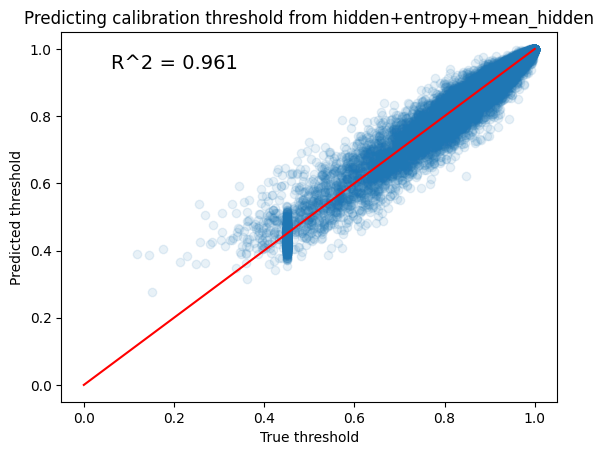

In [41]:
# plot the calibration curve
y_pred = lr.predict(torch.tensor(X_dev, dtype=torch.float32))#.detach().cpu().numpy()
plt.scatter(y_dev, y_pred, alpha = 0.1)
plt.plot([0,1], [0,1], color="red")
plt.xlabel("True threshold")
plt.ylabel("Predicted threshold")

# add R^2 to the plot
r2 = lr.score(X_dev, y_dev)
plt.text(0.1, 0.9, f"R^2 = {r2:.3f}", transform=plt.gca().transAxes, fontsize=14)
plt.title("Predicting calibration threshold from hidden+entropy+mean_hidden")
plt.savefig("calib_learning_hidden+entropy+mean.png", dpi=300)
plt.show()

### Calcualte the empirical calibration error when using this MLP

In [ ]:
# calculate the calibration error: use the threhsold predicted by the model and calculate the calibration error
# NOTE: the results are very sensitive to the threshold (via the value of CONST) 

CONST = 1.05

thr_pred = lr.predict(torch.tensor(X_dev, dtype=torch.float32))#.detach().cpu().numpy()
good, bad = 0,0
preddiction_set_size = []

for probs, threshold , token in tqdm.tqdm(zip(all_probs[split:], thr_pred, tokens[split:])):
    probs_sorted, argsort_idx = torch.sort(torch.tensor(probs), descending=True)
    probs_sorted = probs_sorted.detach().cpu().numpy()
    argsort_idx = argsort_idx.detach().cpu().numpy()
    # find the index i, such that the cumulative sum of probs is higher than the threshold
    cumsum = 0
    for i, p in enumerate(probs_sorted):
        cumsum += p
        if cumsum >= CONST * threshold:
            i += 1
            break
    
    index_correct = np.where(argsort_idx == token)[0][0]

    print(threshold, probs_sorted[:index_correct+1].sum(), cumsum, i, index_correct)
    preddiction_set_size.append(i)
    prediction_set = argsort_idx[:i]
    if token in prediction_set:
        good += 1
    else:
        bad += 1
